# Entropy of parcellations

In [4]:
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.atlas_paper.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as eva
import SUITPy as suit
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt
import os
import nitools as nt
import sys

from pathlib import Path
import numpy as np
import Functional_Fusion.atlas_map as am
import scipy.linalg as sl
import nibabel as nb
import nitools as nt
import re
from copy import deepcopy
import PcmPy as pcm
from matplotlib.colors import ListedColormap


In [5]:
# Figure settings
figsize = (8, 8)
colorbar = False
bordersize = 4
blend = 0.8 # Strength of fade

background='white'
fontcolor='k'
bordercolor='k'
backgroundcolor='w'
fade = 1.0 

# Get matplotlib reds colormap and reverse it
reds = plt.cm.get_cmap('Reds', 256)
reds = reds.reversed()


## Import NettekovenAsym32 parcellation

In [50]:
_, cmap, labels = nt.read_lut(ut.export_dir + 'NettekovenAsym32.lut')
atlas_file = ut.export_dir + 'NettekovenAsym32_space-MNISymC2_probseg.nii'
suit_atlas, _ = am.get_atlas('MNISymC2')
NettekovenAsym_probseg = suit_atlas.read_data(atlas_file)

In [52]:
# Calculate entropy for each voxel of Nettekoven atlas
epsilon = sys.float_info.epsilon
entropy = np.zeros(NettekovenAsym_probseg.shape[0])
for v in range(NettekovenAsym_probseg.shape[0]):
    prob = NettekovenAsym_probseg[v,:]
    # deal with zeros by adding epsilon
    prob = prob + epsilon
    entropy[v] = -np.nansum(prob * np.log(prob))

Text(0.5, 1.0, 'Entropy of Nettekoven atlas')

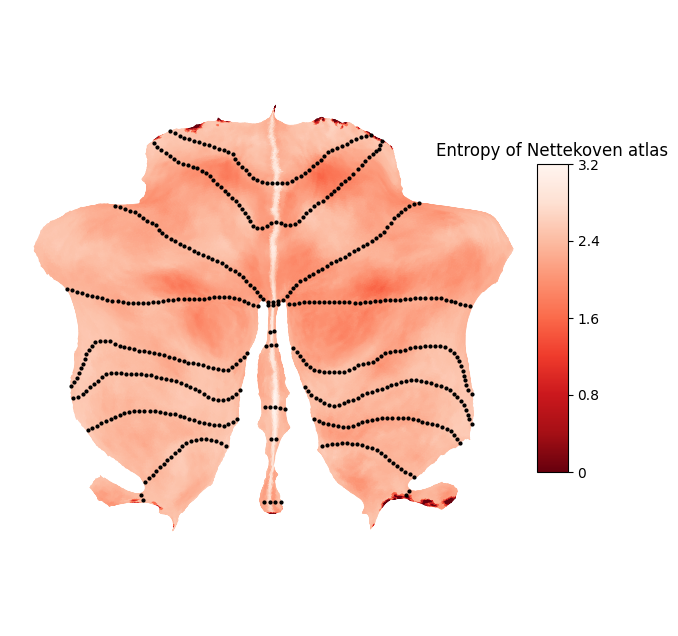

In [54]:
plt.figure(figsize=figsize)
ax = ut.plot_data_flat(data=entropy, atlas='MNISymC2',
                   dtype='func',
                   render='matplotlib',
                   cmap=reds,
                   bordersize=4,
                   bordercolor='k',
                   backgroundcolor='w',
                   colorbar=True)
plt.title('Entropy of Nettekoven atlas')

## Calculate Entropy for each voxel of probabilistic parcellations

In [9]:
dsegs = []
probs = []

comparison_datasets = ['Md', 'Po', 'Ni', 'Ib', 'Wm', 'De', 'So']

for dset in comparison_datasets:
    info, prob = ut.load_batch_best(f'Models_03/asym_{dset}_space-MNISymC3_K-34_arrange-asym_sep-hem')
    prob = prob.marginal_prob().numpy()
    # Get winner take all
    dseg = np.argmax(prob, axis=1) + 1
    # Append
    probs.append(prob)
    dsegs.append(dseg)
    

dsegs = np.stack(dsegs, axis=0)
probs = np.stack(probs, axis=0)



In [13]:
# Calculate entropy of probabilistic parcellations of single datasets
entropies = np.zeros((len(comparison_datasets), probs.shape[2]))
for i in range(len(comparison_datasets)):
    for v in range(probs.shape[2]):
        prob = probs[i, :, v]
        # deal with zeros by adding epsilon
        prob = prob + epsilon
        entropies[i, v] = -np.nansum(prob * np.log(prob))

<Axes: title={'center': 'So'}>

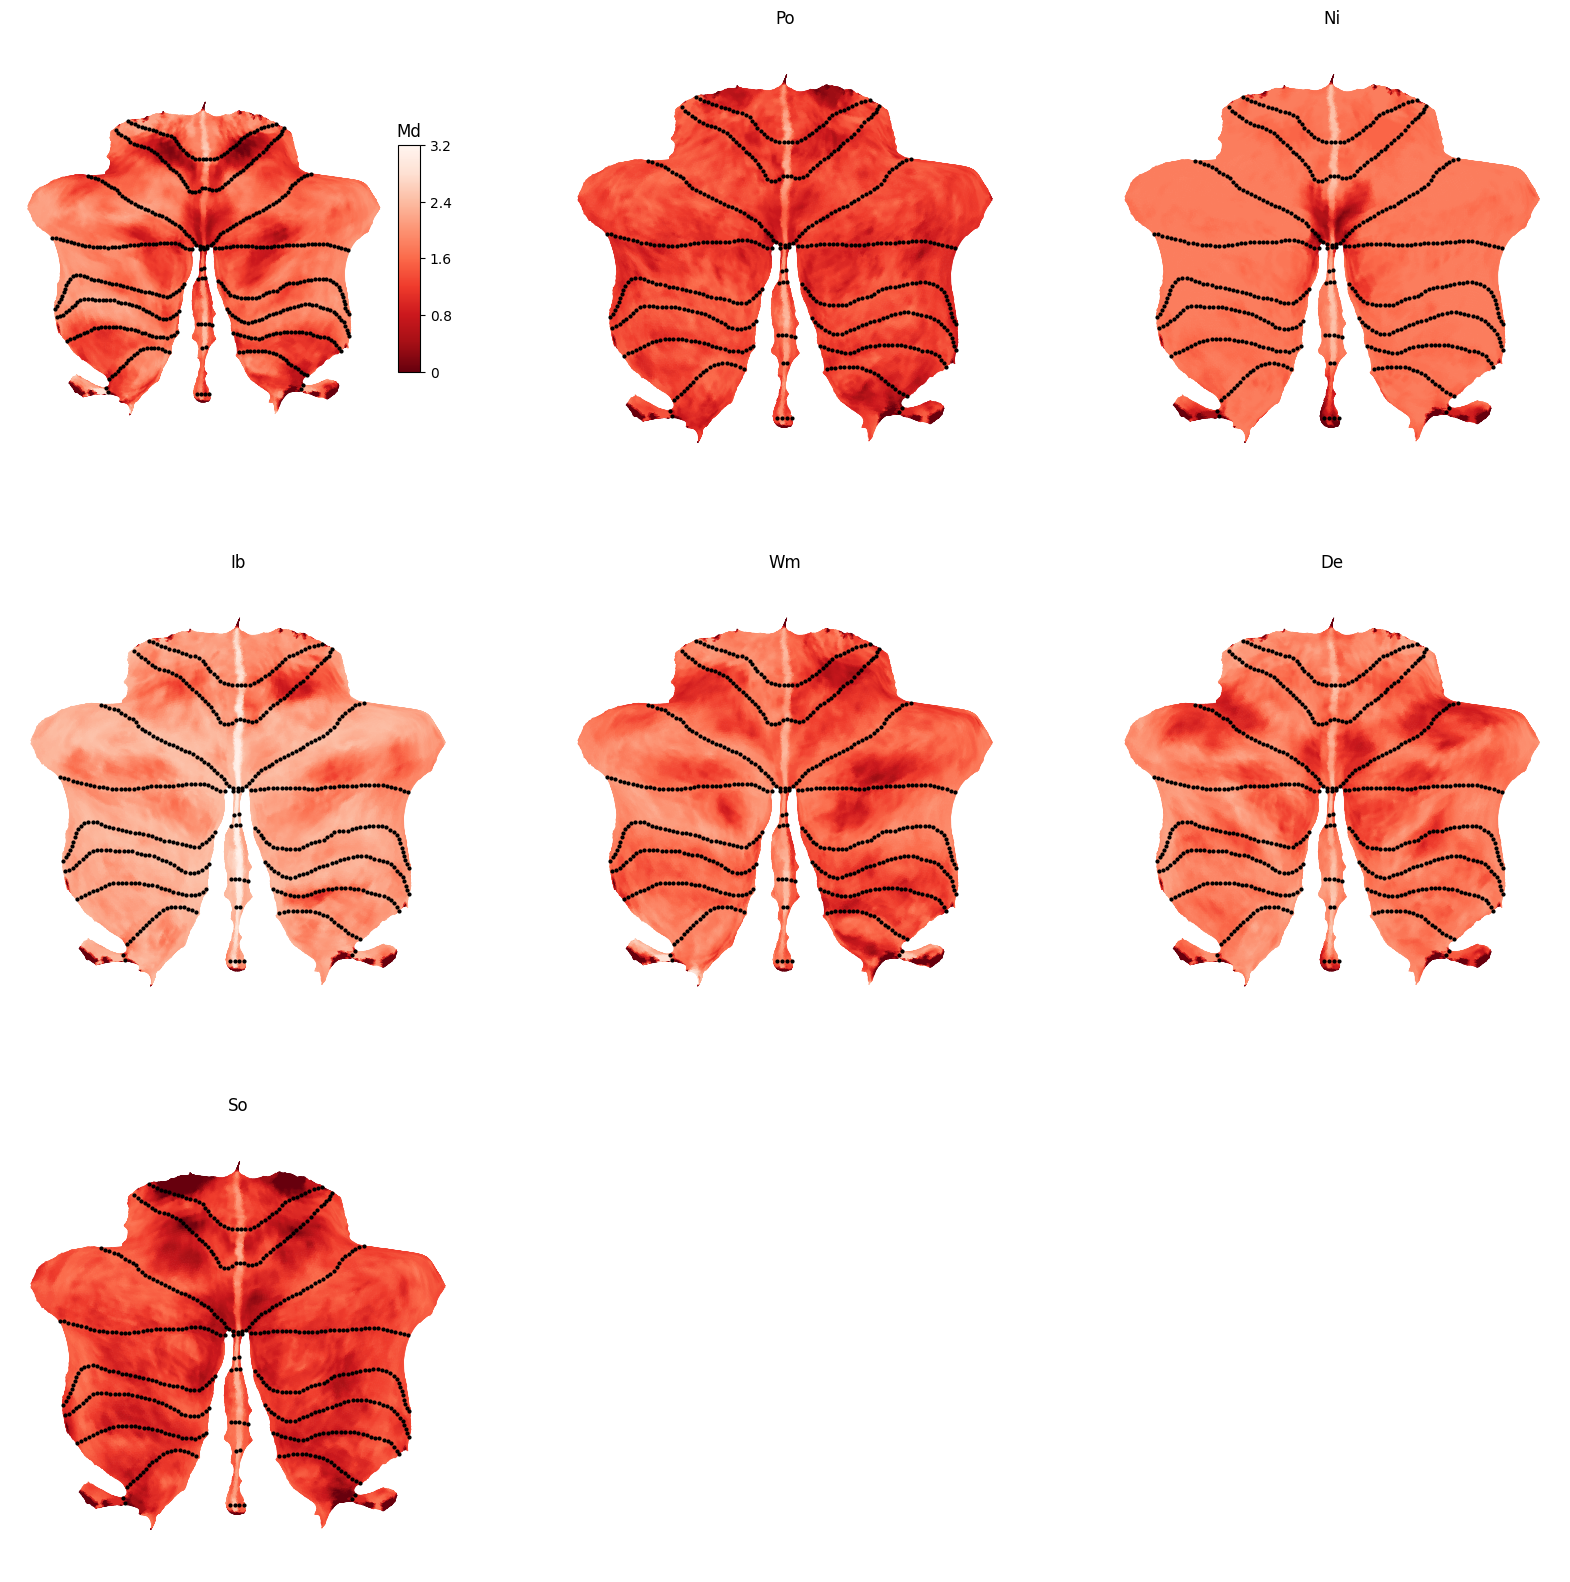

In [55]:
plt.figure(figsize=(20,20))
ut.plot_multi_flat(data=entropies, atlas='MNISymC3',
                   grid=(3, 3),
                   titles=comparison_datasets,
                   dtype='func',
                   cmap=reds,
                   cscale=(0, 3.2),
                   colorbar=True)
